## Softmax Classifier 
### Loading Necessary Libraries

In [79]:
## importing stuff
import time
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from cs231n.data_utils import load_CIFAR10

### Loading Data And Dividing it into differenet sets

In [80]:
# ## loading data
# cifar = tf.keras.datasets.cifar10
# (x_train, y_train), (x_test, y_test) = cifar.load_data()

## loading data from cs231n batch files
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)


## setting up numbers of elements for each set
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

## subsmampling the data for each of the sets one by one

## validation data
mask = list(range(num_training, num_training + num_validation))
x_val, y_val = x_train[mask], y_train[mask]

## training data
mask = list(range(num_training))
x_train, y_train = x_train[mask], y_train[mask]

## test data
mask = list(range(num_test))
x_test, y_test = x_test[mask], y_test[mask]

## dev set data
## dev set data is a subset of the training data created for fast computation of the notebook.
mask = np.random.choice(num_training, num_dev, replace = False)
x_dev, y_dev = x_train[mask], y_train[mask]


### Preprocessing : Reshaping the data into rows
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_dev = x_dev.reshape(x_dev.shape[0], -1)


### Normalizing the data: Subtract The Mean Image
mean_image = np.mean(x_train, axis = 0)
x_train = x_train - mean_image
x_test = x_test - mean_image
x_val = x_val - mean_image
x_dev = x_dev - mean_image


### using the bias trick : adding a vector of ones
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_val = np.hstack([x_val, np.ones((x_val.shape[0], 1))])
x_dev = np.hstack([x_dev, np.ones((x_dev.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

## experimental shit, does adding bias term ahed effects the model in any way
# x_train = np.hstack([np.ones((x_train.shape[0], 1)) , x_train])
# x_val = np.hstack([np.ones((x_val.shape[0], 1)) , x_val])
# x_dev = np.hstack([np.ones((x_dev.shape[0], 1)) ,x_dev])
# x_test = np.hstack([np.ones((x_test.shape[0], 1)) ,x_test])

print('Train Data Shape:        ', x_train.shape)
print('Train Labels Shape:      ', y_train.shape)
print('Validation Data Shape:   ', x_val.shape)
print('Validation Labels Shape: ', y_val.shape)
print('Test Data Shape:         ', x_test.shape)
print('Test Labels Shape:       ', y_test.shape)
print('Dev Data Shape:          ', x_dev.shape)
print('Dev Labels Shape:        ', y_dev.shape)

Train Data Shape:         (49000, 3073)
Train Labels Shape:       (49000,)
Validation Data Shape:    (1000, 3073)
Validation Labels Shape:  (1000,)
Test Data Shape:          (1000, 3073)
Test Labels Shape:        (1000,)
Dev Data Shape:           (500, 3073)
Dev Labels Shape:         (500,)


## Softmax Classifier
### Softmax Loss Naive

In [81]:
def softmax_loss_naive(W, x, y, reg):
    
    ## initializng the loss and gradient to zero
    loss = 0.0
    dW = np.zeros_like(W)
    
    ## num_class and num_train
    num_classes = W.shape[1]
    num_train = x.shape[0]
    
    for i in range(num_train):
        
        ## ----------------------------------------------calculating loss--------------------------------------------
        
        ## calculating score
        score = np.dot(x[i], W)
        
        ## shift values of scores for overflow reasons
        score -= score.max()
        ## currently score is a row vector
        score_expsum = np.sum(np.exp(score))
        
        ## correct class score exponiated
        correct_exp = np.exp(score[y[i]])
        
        ## calculating loss for this example and adding it to the total loss tally
        loss += -np.log(correct_exp/score_expsum)


        ## ----------------------------------------------calculating gradient-----------------------------------------
        
        ## for correct class
        dW[:, y[i]] += (-1) * ( (score_expsum - correct_exp) / (score_expsum) ) * (x[i])
        
        ## for incorrect classes
        for j in range(num_classes):
            
            ## continue if correct class
            if j == y[i]:
                continue
            
            ## for incorrect
            dW[:, j] +=  x[i] * (np.exp(score[j]) / score_expsum)

    ## averaging loss over all training examples
    loss /= num_train
    ## adding regularization to loss
    loss += reg * np.sum(W * W)
    ## averaging gradient
    dW /= num_train
    ## adding regularization to gradient
    dW += 2 * reg * W


    return loss, dW
    
## ---------------------------------------------------function ends here-----------------------------------------------------
        
        

## Generate a random softmax weight matrix and use it to compute loss
W = np.random.randn(3073, 10) * 0.0001

## storing initialized weight into a variable so that I can use same weights for any other computations initially
## which will help me gain a better insight of the problem.
initial_W = W

loss, grad = softmax_loss_naive(W, x_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(1/10). i.e. 1/num_class
print('loss : ',loss)
print('loss should be something around this : ', (-np.log(0.1)))

loss :  2.3656435641839306
loss should be something around this :  2.3025850929940455


### Gradient Checking

### Computing Numerical Gradient And Checking It With The Above Analytically Computed Gradient <br>

In [82]:
from random import randrange

## this function checks numerical and analytic gadients for a function f and parameter x .... [ f'(x) numerically ]

def grad_check(f, x, analytic_grad, num_checks = 10, h = 1e-5):
    
    for _ in range(num_checks):
        ## we'll pick random number of rows and columns in x
        ix = tuple([randrange(m) for m in x.shape])
        
        ## old value is stored in a variable 'oldval'
        oldval = x[ix]
        
        ## x[ix] is increased by h
        x[ix] = oldval + h
        
        ## increment was done only on x[ix] but f calculation will be of f(x) in which h has already been added
        fxph = f(x)
        
        ## same process as above for decrement of h from x[ix]

        x[ix] = oldval - h
        ## calculatiing f(x) where x --> x[ix] = oldval- h
        fxmh = f(x)
        
        ## changing value of x[ix] back to 'oldval'
        x[ix] = oldval
        
        ## mean - centric grad_numerical
        grad_numerical = (fxph - fxmh)/ (2*h)
        
        ## analytic gradient 
        grad_analytic = analytic_grad[ix]
        
        ## relative error
        rel_error = abs( grad_numerical - grad_analytic ) / ( abs(grad_numerical) + abs(grad_analytic) )
        
        print('Numerical : {} Analytic : {} , Relative : {} '.format(grad_numerical, grad_analytic, rel_error))
       
    
## calculating analytic gradient and cost using softmax_loss_vectorized() function        
loss, grad = softmax_loss_naive(W, x_dev, y_dev, 1e2)

## the function f which returns 'softmax loss' for a particular 'w'
f = lambda w : softmax_loss_naive(w, x_dev, y_dev, 1e2)[0] 

## calling the above grad_check() function
grad_numerical = grad_check(f, W, grad)        

Numerical : 3.321923241728086 Analytic : 3.3219229814215328 , Relative : 3.9180099065871316e-08 
Numerical : -1.1534561645376584 Analytic : -1.153456187566482 , Relative : 9.982530759691742e-09 
Numerical : -0.553201978181761 Analytic : -0.5532020152525577 , Relative : 3.350566066790553e-08 
Numerical : 0.8345882901883427 Analytic : 0.8345882479048582 , Relative : 2.5331942743358483e-08 
Numerical : -1.6696505077629096 Analytic : -1.6696505813467015 , Relative : 2.2035686505936127e-08 
Numerical : 0.8718600235546602 Analytic : 0.8718599768792742 , Relative : 2.6767706965026762e-08 
Numerical : -2.2103868960954287 Analytic : -2.210387071505627 , Relative : 3.967861728556281e-08 
Numerical : -0.3819620846057247 Analytic : -0.38196213199604384 , Relative : 6.203536696898208e-08 
Numerical : -1.2103524106077401 Analytic : -1.210352509683293 , Relative : 4.09283890995713e-08 
Numerical : 1.575960465283188 Analytic : 1.5759603665688806 , Relative : 3.1318777552207125e-08 


## Softmax Classifier
### Implementing the vectorized code for Softmax Loss and gradient

In [83]:
def softmax_loss_vectorized(W, x, y, reg):
    
    ## initial loss
    loss = 0.0
    ## intializing weight gradient dW with a matrix of all zeros
    dW = np.zeros_like(W)
    
    ## number of training examples in x
    num_train = x.shape[0]
    ## choosing the value of delta
    delta = 1.0
    
    ##--------------------------------------vectorized loss function-------------------------------------------------
    
    ## x is (num_train,3073) and w is (3073,10) and hence score will be (num_train,10)
    ## this means score will have class score for each training example for all classes    
    scores = np.dot(x,W)
    
    ## shift values of scores for overflow reasons
    scores -= scores.max()
    
    ## exponiating the scores (num_train, 10)
    scores = np.exp(scores)
    
    ## score sum for each example (num_train, 1)
    scores_sums = np.sum(scores, axis = 1)
    
    ## correct exponiated scores (num_train, 1)
    correct = scores[ range(num_train), y]
    
    ## calculating loss
    loss = correct / scores_sums
    loss = -np.sum(np.log(loss))/num_train  + reg * np.sum(W*W)
    
    ##--------------------------------------vectorized grad function-------------------------------------------------
    
    s = np.divide(scores, scores_sums.reshape(num_train, 1))
    s[range(num_train), y] = - (scores_sums - correct) / scores_sums
    dW = x.transpose().dot(s)
    dW /= num_train
    dW += 2 * reg * W
    
    return loss, dW

## Generating a random weight matrix of small numbers
## 3073 for image size and 10 because of number of classes
W = np.random.randn(3073, 10) * 0.0001

## using the initialized value of W
W = initial_W

## calling the softmax_loss_vectorized function
loss, grad = softmax_loss_vectorized(W, x_dev, y_dev, reg = 0.0)
print(loss)

2.3656435641839297


### Comparing Both The Naive And Vectorized Implementations

In [84]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, x_dev, y_dev, 0.000005)
toc = time.time()
naive_time = toc - tic
print('Naive Loss: {} computed in {}s'.format(loss_naive, naive_time))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, x_dev, y_dev, 0.000005)
toc = time.time()
vectorized_time = toc - tic
print('Vectorized Loss: {} computed in {}s'.format(loss_naive, vectorized_time))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: {}'.format(np.abs(loss_naive - loss_vectorized)))
print('Gradient difference: {}'.format(grad_difference))

print('\n\nVectorized Code is About {} times faster than the Naive Implementation When we are using development set.'.format(int(naive_time/vectorized_time) + 1))

Naive Loss: 2.365643565720175 computed in 0.2254776954650879s
Vectorized Loss: 2.365643565720175 computed in 0.007008075714111328s
Loss difference: 8.881784197001252e-16
Gradient difference: 2.3342209697386033e-13


Vectorized Code is About 33 times faster than the Naive Implementation When we are using development set.


### Stochastic Gradient Descent 
### Applying Gradient Descent to optimize the weights and hence train the network <br>

In [85]:
def train(x, y, learning_rate = 1e-3, reg = 1e-5, num_iters = 100, batch_size = 200, verbose = False):
    
    num_train, dim = x.shape
    ## assuming that there will be atleast one example of class (k - 1) when there are k classes from (0) to (k-1) 
    num_classes = np.max(y) + 1
    
    ## intializing parameters
    W = 0.001 * np.random.randn(dim, num_classes)
    
    loss_history = []
    
    for it in range(num_iters):
        ## sampling some random indices
        sample_indices = np.random.choice(np.arange(num_train), batch_size)
        
        ## creating the batches
        x_batch = x[sample_indices]
        y_batch = y[sample_indices]
        
        ## evaluating loss and gradient
        loss, grad = softmax_loss_vectorized(W, x_batch, y_batch, reg)
        loss_history.append(loss)
        
        ## changing the weights
        W = W - learning_rate * grad
        
        ## printing is verbose is true
        if(verbose==True and it%100==0):
            print('Iteration {}/{} : Loss {}'.format(it,num_iters,loss))
                  
    return loss_history, W
        
## calling the train function
loss_hist, new_W = train(x_train, y_train, learning_rate = 1e-7, reg = 2.5e4, num_iters = 1500, verbose = True)
                  
## making new_W equal to W
W = new_W               
                  

Iteration 0/1500 : Loss 781.4808323292893
Iteration 100/1500 : Loss 287.07615814009466
Iteration 200/1500 : Loss 106.28925766033674
Iteration 300/1500 : Loss 40.20388833036623
Iteration 400/1500 : Loss 16.012885326608014
Iteration 500/1500 : Loss 7.186568115451111
Iteration 600/1500 : Loss 3.999669270425492
Iteration 700/1500 : Loss 2.7052239391572135
Iteration 800/1500 : Loss 2.3368383080218504
Iteration 900/1500 : Loss 2.1446024645914665
Iteration 1000/1500 : Loss 2.0703453936469156
Iteration 1100/1500 : Loss 2.071412616750884
Iteration 1200/1500 : Loss 2.159137224429835
Iteration 1300/1500 : Loss 2.1216063543892947
Iteration 1400/1500 : Loss 2.0858875834372026


### Plotting The Loss_History Curve

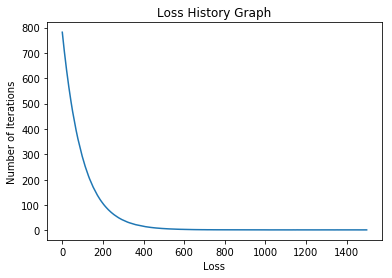

In [86]:
## plotting the graph
plt.plot(loss_hist)
plt.xlabel('Loss')
plt.ylabel('Number of Iterations')
plt.title('Loss History Graph')
plt.show()

### Predicting on Training And Validation Sets

In [87]:
## making a function to return predictions using the trained weights

def predict(x):
    
    y_pred = np.zeros((x.shape[1]))
    
    ## currently y_pred has a shape of (N,C) where C is number of classes in x i.e. this is a collection of 1 hot arrays
    y_pred = np.dot(x, W)
    
    ## converting from 1 hot array to 1 dimensional array
    y_pred = np.argmax(y_pred, axis = 1)
    
    return y_pred

## predictions on the training set

y_train_pred = predict(x_train)
## calculating accuracy on the training set
train_accuracy = np.mean(y_train_pred == y_train)
print('Train Accuracy : {}\n\n'.format(train_accuracy))


## predictions on the validation set

y_val_pred = predict(x_val)
## calculating accuracy on the validation set
val_accuracy = np.mean(y_val_pred == y_val)
print('Validation Accuracy : {}\n\n'.format(val_accuracy))


Train Accuracy : 0.3321224489795918


Validation Accuracy : 0.35




### Tuning The Hyperparameters

In [91]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

results = {}
best_val = -1
learning_rates = [1e-8, 1e-7, 5e-7, 1e-6]
regularization_strengths = [5e2, 1e3, 1e4, 5e4]

for lr in learning_rates:
    for reg in regularization_strengths:
        
        ## calling train function()
        loss_hist, W = train(x_train, y_train, learning_rate = lr, reg = reg, num_iters = 1500)
        
        ## train accuracy
        y_train_pred = predict(x_train)
        acc_train = np.mean(y_train == y_train_pred)
        
        ## validation accuracy
        y_val_pred = predict(x_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        ## appending data into the dictionary
        results[(lr, reg)] = (acc_train, acc_val)
        
        if acc_val > best_val:
            best_val = acc_val
        
for lr,reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('learning rate: {}, regularization: {}, train accuracy: {}, validation accuracy: {} '.format(lr, reg, train_accuracy, val_accuracy))

print("Best Validation Accuracy Achienved During Cross Validation is : ", best_val)

learning rate: 1e-08, regularization: 500.0, train accuracy: 0.156265306122449, validation accuracy: 0.181 
learning rate: 1e-08, regularization: 1000.0, train accuracy: 0.14881632653061225, validation accuracy: 0.151 
learning rate: 1e-08, regularization: 10000.0, train accuracy: 0.14993877551020407, validation accuracy: 0.168 
learning rate: 1e-08, regularization: 50000.0, train accuracy: 0.22440816326530613, validation accuracy: 0.229 
learning rate: 1e-07, regularization: 500.0, train accuracy: 0.253, validation accuracy: 0.254 
learning rate: 1e-07, regularization: 1000.0, train accuracy: 0.2630612244897959, validation accuracy: 0.284 
learning rate: 1e-07, regularization: 10000.0, train accuracy: 0.3526326530612245, validation accuracy: 0.358 
learning rate: 1e-07, regularization: 50000.0, train accuracy: 0.30028571428571427, validation accuracy: 0.316 
learning rate: 5e-07, regularization: 500.0, train accuracy: 0.3642448979591837, validation accuracy: 0.365 
learning rate: 5e-0

In [93]:
## evaluate the best hyperparameters model on the test set
loss_history, W = train(x_train, y_train, learning_rate = 1e-6, reg = 1000, num_iters = 1500, verbose = True)

y_test_pred = predict(x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('\n\nSoftmax Test Set Accuracy: ',test_accuracy)

Iteration 0/1500 : Loss 37.21362354816587
Iteration 100/1500 : Loss 22.93850903159185
Iteration 200/1500 : Loss 15.583849615517943
Iteration 300/1500 : Loss 10.933157288261494
Iteration 400/1500 : Loss 7.94550483563213
Iteration 500/1500 : Loss 5.778068254866871
Iteration 600/1500 : Loss 4.516625572139345
Iteration 700/1500 : Loss 3.617066110020545
Iteration 800/1500 : Loss 3.0092109823271436
Iteration 900/1500 : Loss 2.6483093179423185
Iteration 1000/1500 : Loss 2.4725255121777123
Iteration 1100/1500 : Loss 2.138589231445844
Iteration 1200/1500 : Loss 2.1404539702866985
Iteration 1300/1500 : Loss 1.889610377576432
Iteration 1400/1500 : Loss 2.0159145773573925


Softmax Test Set Accuracy:  0.385


### Visualize The Learned Weights For Each Class

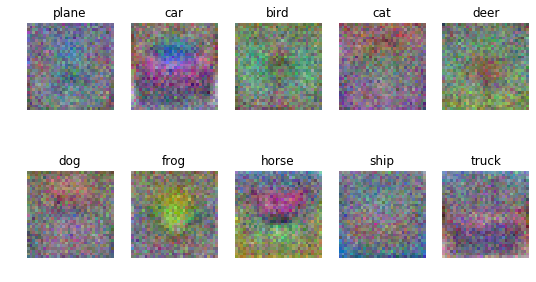

In [99]:
### strip out the bias
w = W[ :-1, :]
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

## adjusting figure size
plt.figure(figsize = (9,5))

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    
    ## adding to the subplot
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])